<a href="https://colab.research.google.com/github/chensar6/APS360/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls -a "/content/drive/MyDrive/APS360_Images"

Mounted at /content/drive
"Ahmed's Colab.ipynb"		 Final_Data_Acc       Test.ipynb
 bounding_box_processing.ipynb	 .ipynb_checkpoints
 Final_Data			 Raw_Data


In [3]:
import os
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt

-----
----
The following is for rotating and saving images

In [ ]:
# function to rotate and resize the image
# will want to save these, I still need to look into saving- Narender
def rotateResizeImage(img):
  img1 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  img2 = cv2.rotate(img, cv2.ROTATE_180)
  img3 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

  rotated_images = [img, img1, img2, img3]
  resized_images = []

  for r_img in rotated_images:
    # Get the dimensions of the original image
    height, width, _ = r_img.shape

    # Determine the padding required to make the image square
    diff = abs(height - width)
    padding = diff // 2

    # Pad the image with zeros
    if height > width:
        r_img = cv2.copyMakeBorder(r_img, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        r_img = cv2.copyMakeBorder(r_img, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Resize the image to 256x256
    resized = cv2.resize(r_img, (256, 256))
    resized_images.append(resized)

  return resized_images


FOLDER 1 OUT OF 3...



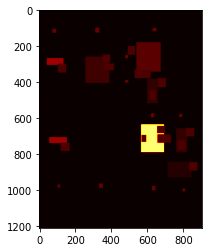

C92_D2_P2.jpg
C92_D2_P2_Rotated0.jpg


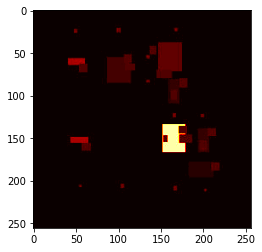

In [ ]:
##this is what actually saves it
from google.colab.patches import cv2_imshow #to display

# makes our life easier by automating
input_folders = ["y_raw"]
output_folders = ["y"]

for i in range(len(input_folders)):
  print("\nFOLDER " + str(i + 1) + " OUT OF 3...\n")
  
  #change the following to work with any input folder and output folder
  input_path ="/content/drive/MyDrive/APS360_Images/Raw_Data/" + input_folders[i] #this is where the images are coming from 
  output_path= "/content/drive/MyDrive/APS360_Images/Final_Data_Acc/" + output_folders[i] #this is where the roated images are going

  #if changing the paths, make sure to change the following line as well. 
  i_images = [(os.path.join(input_path, f), f) for f in os.listdir(input_path) if (f.endswith('.jpg'))]
  o_images = [(os.path.join(output_path, f), f) for f in os.listdir(output_path) if (f.endswith('.jpg'))]

  import random
  k = random.randint(0, len(i_images))

  i_img = cv2.imread(i_images[k][0])
  i_img = cv2.cvtColor(i_img, cv2.COLOR_BGR2GRAY)

  plt.imshow(i_img, cmap="hot")
  plt.show()

  print(i_images[k][1])

  z = int()
  for i, (f1, f2) in enumerate(o_images):
    if (i_images[k][1].split(".")[0] in f2) and ("Rotated0" in f2):
      z = i
      break
  
  print(o_images[z][1])
  o_img = cv2.imread(o_images[z][0])
  o_img = cv2.cvtColor(o_img, cv2.COLOR_BGR2GRAY)
  plt.imshow(o_img, cmap="hot")
  plt.show()
  """
  #this sets the output dir as current dir
  os.chdir(output_path)

  numOfImages= len(images)

  # Clean memory
  gc.collect()

  for i in range(numOfImages):
    image = cv2.imread(images[i][0])
    imageRotated=rotateResizeImage(image)
    
    #save all the images with edited names, including the original
    cv2.imwrite( images[i][1].replace('.jpg', '_Rotated0.jpg'), cv2.cvtColor(imageRotated[0], cv2.COLOR_BGR2RGB))
    cv2.imwrite( images[i][1].replace('.jpg', '_Rotated90.jpg'), cv2.cvtColor(imageRotated[1], cv2.COLOR_BGR2RGB))
    cv2.imwrite( images[i][1].replace('.jpg', '_Rotated180.jpg'), cv2.cvtColor(imageRotated[2], cv2.COLOR_BGR2RGB))
    cv2.imwrite( images[i][1].replace('.jpg', '_Rotated270.jpg'), cv2.cvtColor(imageRotated[3], cv2.COLOR_BGR2RGB))
    print("Done processing image {0}/1152...".format(i+1))"""

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [39]:
from operator import truediv
# Code to retrieve data and make DataLoaders
# 0.8, 0.1, 0.1 split?

# Define custom dataset class that inherits from torch Dataset in order to load data
class ImageDataset(Dataset):
    def __init__(self, root_dir, bool_RGB=True, num_classes=46):
        self.x_dir = os.path.join(root_dir, "x_RGB" if bool_RGB else "x_gray")
        self.y_dir = os.path.join(root_dir, 'y')
        
        self.filenames = os.listdir(self.x_dir)
        self.bool_RGB = bool_RGB
        self.num_classes = num_classes
        
        # Define transform to convert images to Tensors that can be fed to model directly
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        x_path = os.path.join(self.x_dir, self.filenames[idx])
        y_path = os.path.join(self.y_dir, self.filenames[idx])

        x = self.transform(Image.open(x_path).convert('RGB' if self.bool_RGB else "L")).to(torch.float32)

        # Convert image to tensor, clip values to num_classes, 
        # then one-hot encode the labellings
        # Then convert to NCHW format, then convert to float32
        y = torch.from_numpy(np.array(Image.open(y_path).convert("L")))
        y = torch.clamp(y, max=self.num_classes-1)
        y = F.one_hot(y.to(torch.int64), self.num_classes)
        y = y.permute(2, 0, 1).to(torch.float32)

        return x, y


# Define the dataset and separate training, val, test
torch.manual_seed(1000)
dataset = ImageDataset("/content/drive/MyDrive/APS360_Images/Final_Data_Acc/", bool_RGB=True) # set to false if training on grayscale

# Calculate the number of examples for each split
num_train = int(len(dataset) * 0.8)
num_val = int(len(dataset) * 0.1)
num_test = len(dataset) - num_train - num_val

# Split the dataset into three parts
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_val, num_test])

"""
# Create DataLoaders for each part
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)"""

'\n# Create DataLoaders for each part\nbatch_size = 32\n\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\nval_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)\ntest_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)'

In [40]:
print(len(dataset))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
for (input, label) in train_dataloader:
  print(input.shape)
  break

4608
torch.Size([32, 3, 256, 256])


In [73]:
import torchvision.models as models

class Autoencoder(nn.Module):
    def __init__(self, num_components):
        super(Autoencoder, self).__init__()
        # input size = 1024*1024
        self.num_components = num_components
        self.resnet = models.resnet50(pretrained=True)
        # Remove the last linear layer and replace it with a convolutional layer
        self.encoder = nn.Sequential(*list(self.resnet.children())[:-1], nn.Conv2d(2048, 4096, kernel_size=1))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4096, 2048, kernel_size=2, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 60, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(60, 55, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(55, 50, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(50, self.num_components, kernel_size=3, stride=2, padding=1),
            nn.Tanh()
        )

    def forwardRGB(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def forwardGray(self, x):
        x = np.repeat(x[..., np.newaxis], 3, -1) # repeat the gray cahnnel for 3 channels. double check this
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [77]:
def trainModel(model, train_data, valid_data, num_epochs=5, batch_size=64, learning_rate=1e-3, plot = True, model_forward=None):
    # Move stuff to GPU
    #  
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # torch.cuda.empty_cache()
    torch.manual_seed(42)

    # model.to(device)

    criterion = nn.CrossEntropyLoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    scaler = GradScaler()
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

    train_loss_total, valid_loss_total = [], []
    
    for epoch in range(num_epochs):
        # Clear ram to save from crashing
        gc.collect()

        for train_img, train_label in train_loader:

            # train_img = train_img.to(device)
            # train_label = train_label.to(device)

            train_output = model_forward(train_img)

            # Compute the loss
            print(train_label.shape)
            print(train_output.shape)
            train_loss = criterion(train_output, train_label)

            #train_img = train_img.view(-1, 1024*1024*3)
            print(train_loss)
            #train_loss.backward()
            # Backward pass
            scaler.scale(train_loss).backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            #optimizer.step()
            #optimizer.zero_grad()

            # Update the weights
            scaler.step(optimizer)
            
            # Update the scaler for mixed precision training
            scaler.update()
        
        for valid_img, valid_label in valid_loader:
            valid_output = model_forward(valid_img)
            valid_loss = criterion(valid_output, valid_label)

        print('Epoch:{}, Train Loss:{:.4f}, Valid Loss:{:.4f}'.format(epoch+1, float(train_loss), float(valid_loss)))
        train_loss_total.append(train_loss.cpu().detach().numpy())
        valid_loss_total.append(valid_loss.cpu().detach().numpy())
        
        
    if plot:
        plt.title("Training/Validation loss")
        plt.plot(train_loss_total, label="Training Loss")
        plt.plot(valid_loss_total, label="Validation Loss")
        plt.xlabel("Iterations")
        plt.legend(loc='best')
        plt.show()
        
        # plt.figure()
        # plt.title("Training/Validation loss")
        # plt.plot(train_accs, label="Training Accuracy")
        # plt.plot(val_accs, label="Validation Accuracy")
        # plt.xlabel("Iterations")
        # plt.legend(loc='best')
        # plt.show()
         
    # Save the model
    torch.save(model.state_dict(), type(model).__name__ + "lr{0}_bs{1}_ep{2}".format(learning_rate, batch_size, num_epochs))

    return train_loss_total, valid_loss_total

In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
for img, label in train_loader:
  print(label.shape)
  break

torch.Size([64, 46, 256, 256])


In [ ]:
# Clear ram before defining model
gc.collect()

autoencoder = Autoencoder(num_components=46)

trainModel(autoencoder, 
           train_data=train_dataset, 
           valid_data=val_dataset, 
           batch_size=32, 
           num_epochs=5, 
           learning_rate=0.0001,
           model_forward=autoencoder.forwardRGB)

torch.Size([32, 4096, 1, 1])
